# Classifying Twitter users based on their tweets
In this workshop we will figure out who wrote which tweets from Norwegian celebrities.


In [1]:
import datetime
import jsonlines
import os
import pandas as pd
import numpy as np
%matplotlib inline

## Build dataset
First we need to build our dataset.
This is not really part of the workshop, but the preparation code is left here so that those interested can check it out later.
In the data directory there is some files from the twitter users we will investigate.
Basically what we do is the following:

- Read the files and put them in a nice pandas dataframe
- Build a vocabulary of all words and give them indicies
- Transform all tweets into indicies (something required by tensorflow later)


#### Read files 

In [2]:
# Read files:
def load_files_and_create_dataframe():
    files = ['data/' + f for f in os.listdir("data")]
    L = []
    for path in files:
        try:
            with jsonlines.open(path, mode='r') as reader:
                tmp = [line for line in reader.iter()]
                if len(tmp) > 50 & isinstance(tmp, list):
                    L.extend(tmp)
                else:
                    print("%s had less than 50 tweets. skipping.." %path)
        except:
            print("Did not manage to process: %s" % path) 
            
    raw = pd.DataFrame(L)
    raw.timestamp = pd.to_datetime(raw.timestamp)
    
    # Shuffle dataset and filter out some users that have sneaked into the files 
    # (i.e. have less than 50 observations)
    
    counts = raw.user.value_counts()
    counts = counts[counts > 50]
    keep_users = counts.index
    
    raw = (
        raw[raw.user.isin(keep_users)]
        .sample(frac=1) # shuffle dataset
        .reset_index(drop=True)
    )
    return raw

raw = load_files_and_create_dataframe()

print("We got %d observations in our dataset. The first 5 looks like this:" % raw.shape[0])
raw.head()

Did not manage to process: data/.DS_Store
We got 122479 observations in our dataset. The first 5 looks like this:


,id,likes,retweets,text,timestamp,url,user
0,8054916719312896,0,0,@OJacobsen Du kan seriøst ikke ha ment at jeg ...,2010-11-26 23:00:00,/lenealexandra/status/8054916719312896,lenealexandra
1,416268617236217856,2,5,Odvar Solbergs vei: Melding om brann. Nødetate...,2013-12-28 16:00:00,/oslopolitiops/status/416268617236217856,oslopolitiops
2,893608537397526528,6,3,Kjelsås: Hundepatrulje og noen andre patruljer...,2017-08-05 11:00:00,/oslopolitiops/status/893608537397526528,oslopolitiops
3,801173754407632896,12,4,Politiet er i nedre del av Bogstadveien. Vi ha...,2016-11-23 19:00:00,/oslopolitiops/status/801173754407632896,oslopolitiops
4,12083964575490048,0,0,@julius68 Jeg klarer å skille mellom drøm og v...,2010-12-08 02:00:00,/lenealexandra/status/12083964575490048,lenealexandra


#### Build vocabulary
We build a vocabulary of the "known" words in the dataset.
Essentially we will require that we have seen the word 5 times before for it to be in the vocabulary.
Otherwise, we will replace the word with "UNK".

The rest is pretty straightforward. 
We split by space and only keep the most important characters in the words.


In [3]:
import re
def tokenizeString(s):
    s = s.lower().strip()
    s = re.sub(u"([.!?])", r" ", s)
    s = re.sub(u"[^a-zA-Z.!#@?\xf8\xe6\xe5]+", u" ", s)
    s = s.split(" ")
    return s

def build_vocabulary(text, min_count = 5):
    normalized = text.map(tokenizeString)
    all_words = np.array([item for sublist in normalized.values.tolist() for item in sublist])
    words, counts = np.unique(all_words, return_counts=True)
    keep_words = words[counts > min_count]
    ind2word = {i + 2 : w for i, w in enumerate(keep_words)}
    ind2word[1] = "UNK"
    ind2word[0] = "EMPTY"
    word2ind = {w : i for i, w in ind2word.items()}
    
    return word2ind, ind2word

word2ind, ind2word = build_vocabulary(raw.text)
print("We have a total vocabulary of %d words." % len(word2ind))


We have a total vocabulary of 14780 words.


In [4]:
print("If you want to find the index of a word:")
print( word2ind["hus"] )
print("Similarly: If you want to find the word corresponding to an index:")
print( ind2word[5] )

If you want to find the index of a word:
6456
Similarly: If you want to find the word corresponding to an index:
#adaxbycarolinebergeriksen


#### Preprocess text
Now we want to transform all tweets from words to a fixed length index.
We do this in two steps:
- First we transform each word into an index (the vocabulary we defined above)
- Then we set all tweets to a length of 40. If a tweet does not have 40 words then we fill with empty words. If the tweet have more, we truncate the end.

The whole process is contained in the encode_text function. Also see that we have a decode_tweet function to go back again!

In [5]:
# Prepare sequences:
from keras.preprocessing.sequence import pad_sequences
vectorize_tweet = lambda x: [word2ind.get(w,1) for w in x]
PAD_LENGTH = 40

def encode_text(s, padlen = PAD_LENGTH):
    tokenized = tokenizeString(s)
    vectorized = vectorize_tweet(tokenized)
    padded = pad_sequences([vectorized], maxlen = padlen, padding = "post", truncating= "post")
    return padded

def decode_tweet(vec):
    dec = [ind2word.get(ind) for ind in vec if ind != 0]
    return " ".join(dec)

# All the work happens here:
X = np.squeeze(np.array(raw.text.map(encode_text).values.tolist()))#.shape

Using TensorFlow backend.


In [6]:
print("We now have all our tweets in the numpy array X. Each row is a tweet (in total %d), and each column is a word (in total %d)" % (X.shape[0], X.shape[1]))

print("We can easily decode a tweet by doing the following:")
decode_tweet(X[40,])

We now have all our tweets in the numpy array X. Each row is a tweet (in total 122479), and each column is a word (in total 40)
We can easily decode a tweet by doing the following:


'den UNK er en eldre kvinne obre vil holde på med slukking i timer til men bygget er UNK '

#### Preprocess labels
Each author represent a class. The classes needs to be represented by indicies.
Therefore, we will also transform all the usernames into numbers.

In [7]:
from sklearn import preprocessing
def build_classes(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    label_index = le.transform(labels)
    ind2class = {i : user for i, user in  enumerate(le.classes_)}
    return label_index, ind2class

raw['user_class'], ind2class = build_classes(raw['user'])
N_classes = len(ind2class) # Store total number of authors somewhere
print("The index -> author mapping can be found in this dictionary:")
ind2class

The index -> author mapping can be found in this dictionary:


{0: 'Fotballfrue',
 1: 'HadiaTajik',
 2: 'konservativ',
 3: 'lenealexandra',
 4: 'oslopolitiops'}

In [8]:
y = raw.user_class.values

#### Split into training and test
When we build our model it is important that we test on a different dataset than we train on.
Otherwise, we could just have written a lookup table to predict each tweet author.
Instead, we want the model to be able to generalize 
i.e. that it in some sense understand what makes a tweet belong to that author.

When we train the algorithm, it will only see the training data. 
Then, when we have finished training, we see how well it is doing on the test data.

We split the data in 80% for training and 20% for testing.

In [9]:
np.random.seed(42)
train_ind = np.random.rand(X.shape[0]) < 0.8
X_train = X[train_ind,]
X_test = X[~train_ind,]
y_train = y[train_ind]
y_test = y[~train_ind]
assert(len(np.unique(y_train)) ==  len(np.unique(y_test)))

print("We have %d tweets in training set and %d tweets in the test set"% (X_train.shape[0], X_test.shape[0]))

We have 97987 tweets in training set and 24492 tweets in the test set


## Start here
This is where the machine learning starts.
Hopefully, you havent really looked at what we did above, so there will be short recap of what we have right now.

Data:
We have many tweets stored in X_train and X_test.
We have five classes that represent five different twitter accounts. The truth of each tweet in X is found in a variable y.

... need to finish this ...

## Build machine learning model
We will build neural networks.

Explain:
- linear regression
- word embeddings

... finish this bit as well ...

In [10]:
import keras
from keras.layers import *
from keras.models import Model

In [26]:
tweet_input = Input((PAD_LENGTH,))
emb = Embedding(input_dim = len(ind2word), output_dim= 5)

# We can represent each word as a vector of length 5:
word_vectors = emb(tweet_input)

# These word vectors are generic, 
# The simplest way to handle them is just to use the average word vector:
avg_word_vectors = Lambda(lambda x: K.mean(x, 1))(word_vectors)
x = avg_word_vectors
x = Dropout(0.2)(x)
x = Dense(20, activation = "relu")(x)
#x = Dropout(0.2)(x)
#x = Dense(100)(x)
#x = Dropout(0.2)(x)
x = Dense(N_classes, activation = "softmax")(x)


model = Model(inputs = tweet_input, outputs = x)

optimizer = keras.optimizers.SGD(lr = 0.05)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = optimizer, 
              metrics=["accuracy"])

In [27]:
model.fit(X_train,y_train, 
          verbose = 2,
          validation_data = (X_test, y_test),
         epochs = 10)

Train on 97987 samples, validate on 24492 samples
Epoch 1/15
8s - loss: 1.2369 - acc: 0.4955 - val_loss: 1.2056 - val_acc: 0.5512
Epoch 2/15
7s - loss: 1.0630 - acc: 0.6158 - val_loss: 0.9002 - val_acc: 0.7211
Epoch 3/15
7s - loss: 0.8394 - acc: 0.7005 - val_loss: 0.6956 - val_acc: 0.7486
Epoch 4/15
7s - loss: 0.7201 - acc: 0.7459 - val_loss: 0.9269 - val_acc: 0.6647
Epoch 5/15
7s - loss: 0.6434 - acc: 0.7777 - val_loss: 0.7705 - val_acc: 0.7423
Epoch 6/15
7s - loss: 0.5972 - acc: 0.7944 - val_loss: 0.5321 - val_acc: 0.8155
Epoch 7/15
7s - loss: 0.5680 - acc: 0.8055 - val_loss: 0.5826 - val_acc: 0.8175
Epoch 8/15
7s - loss: 0.5460 - acc: 0.8133 - val_loss: 0.4770 - val_acc: 0.8409
Epoch 9/15
7s - loss: 0.5273 - acc: 0.8193 - val_loss: 0.4737 - val_acc: 0.8286
Epoch 10/15
7s - loss: 0.5183 - acc: 0.8237 - val_loss: 0.4798 - val_acc: 0.8247
Epoch 11/15
7s - loss: 0.5011 - acc: 0.8292 - val_loss: 0.5056 - val_acc: 0.8253
Epoch 12/15
7s - loss: 0.4892 - acc: 0.8337 - val_loss: 0.6216 - val

## See how well the model works

In [28]:
# Predict probabilities for each class:
yhat_probs = model.predict(X_test)
yhat = yhat_probs.argmax(axis=1)

In [29]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,yhat)
#confusion

In [30]:
rel_confusion = np.round(confusion / confusion.sum(axis=1, keepdims = True),2)
rel_confusion = pd.DataFrame(rel_confusion, columns = ind2class.values(), index= ind2class.values())
rel_confusion.index.name = "true"
rel_confusion.columns.name = "predicted"
rel_confusion

predicted,Fotballfrue,HadiaTajik,konservativ,lenealexandra,oslopolitiops
true,,,,,
Fotballfrue,0.82,0.00,0.02,0.15,0.01
HadiaTajik,0.05,0.03,0.50,0.40,0.01
konservativ,0.01,0.01,0.50,0.45,0.03
lenealexandra,0.00,0.00,0.02,0.97,0.00
oslopolitiops,0.00,0.00,0.01,0.03,0.97


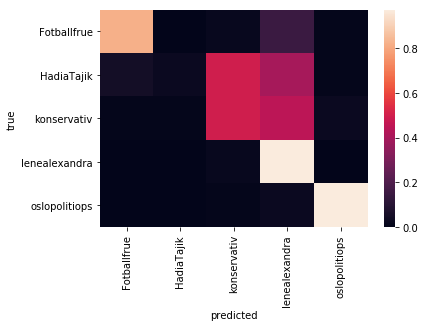

In [31]:
import seaborn as sns
sns.heatmap(rel_confusion)

In [32]:
def show_random_error():
    errors = np.where(y_test != yhat)[0]
    idx = np.random.choice(errors)
    print('--- Tweet: ---')
    print(decode_tweet(X_test[idx,]))
    
    print("Model believes:\t %s" %ind2class[yhat[idx]])
    print("True author:\t %s" %ind2class[y_test[idx]])

In [42]:
show_random_error()

--- Tweet: ---
stortinget skal debattere UNK i dag mitt tips kongen kan føle seg nokså trygg på jobben 
Model believes:	 lenealexandra
True author:	 konservativ


## Now it's your turn..

Are you able to make a better model than the one we just ran? 

Possible extensions of the model:

- Try to increase the width of the dense layer (https://keras.io/layers/core/#dense)
- Try to adjust the learning rate of your optimizer. Lower learning rates takes long but usually gives better results (https://keras.io/optimizers/)
- Try to use a different optimizer. The Adam optizer is often a good alternative 
- Try to stack another dense layer on top of the one you have (or many!)
- We are just using the "average" vector to predict. Could we try to stack the words horizontally instead? (https://keras.io/layers/core/#reshape)
- Are the training accuracy much higher than the test accuracy? Try to add Dropout (https://keras.io/layers/core/#dropout) or Batch Normalization (https://keras.io/layers/normalization/)
- Instead those average vectors, a very fancy alternative approach would be to try to model a tweet as a recurrent neural network (https://keras.io/layers/recurrent/)